### Introduction

**What are Graph-based Neighborhoods?** üï∏Ô∏è
As you've learned from the last spatial graphs [tutorial](../graphs/), a graph is the ideal data structure for defining and analyzing neighborhoods. In this context, a spatial graph is created where each nucleus is a node. The links between these nodes (the "edges") represent a spatial relationship, such as physical contact or proximity. This graph structure is what allows us to precisely define a nucleus's neighborhood as the collection of its directly linked neighbors.

**What Can We Measure in a Neighborhood?** üî¨
For every single-cell neighborhood, Histolytics can compute a variety of metrics that fall into three main categories:

**Summary characteristics:** These are aggregate statistics that describe the overall properties of the neighborhood. For a specific nucleus, you can compute:

- The number of specific neighbors
- mean/std/median/min/max/etc of nuclear features of all the neighboring nuclei.

**Distances:** These can be used to quantify spatial arrangements of nuclei (dense packing vs. loose packing)

- The mean/std/median/min/max/etc distance to all neighboring nuclei.

**Heterogeneity of neighboring features or cell types:** These are measures of diversity within the neighborhood. Available metrics include:

- Shannon entropy
- Simpson's diversity index
- Gini coefficient
- Theil index

In this tutorial, we will explore how to compute these neighborhood metrics. We will use a small HGSC dataset as our example.

index  focal  neighbor  weight  focal_centroid_x  focal_centroid_y  \
0      0      0         1     1.0       1400.037980          1.692484   
1      1      0         4     1.0       1400.037980          1.692484   
2      6      1         4     1.0       1386.458579          9.580762   
3      9      2         3     1.0       1378.296689        170.695478   
4     13      2        23     1.0       1378.296689        170.695478   

   neighbor_centroid_x  neighbor_centroid_y focal_class_name  \
0          1386.458579             9.580762       connective   
1          1306.059654             2.527988       connective   
2          1306.059654             2.527988       connective   
3          1318.355274           178.923534       connective   
4          1367.454971           219.690997       connective   

  neighbor_class_name             class_name  \
0          connective  connective-connective   
1          connective  connective-connective   
2          connective  connective-connective   
3          connective  connective-connective   
4          connective  connective-connective   

                                          geometry  
0      LINESTRING (1400.038 1.692, 1386.459 9.581)  
1       LINESTRING (1400.038 1.692, 1306.06 2.528)  
2       LINESTRING (1386.459 9.581, 1306.06 2.528)  
3  LINESTRING (1378.297 170.695, 1318.355 178.924)  
4  LINESTRING (1378.297 170.695, 1367.455 219.691)

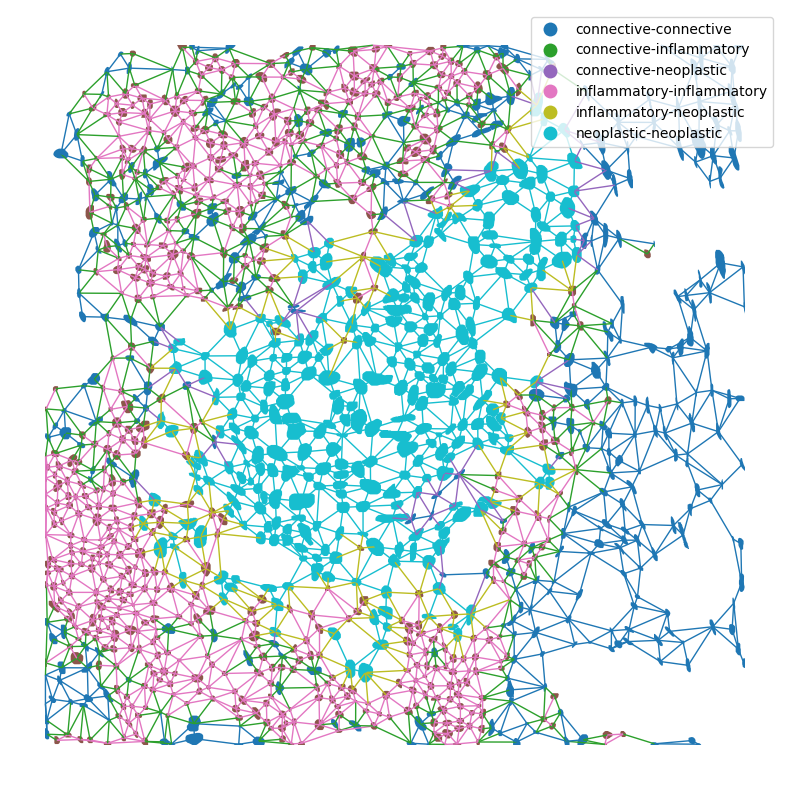

In [1]:
from histolytics.spatial_graph.graph import fit_graph
from histolytics.utils.gdf import set_uid
from histolytics.data import hgsc_cancer_nuclei

nuc = hgsc_cancer_nuclei()
nuc = set_uid(nuc)  # Ensure the GeoDataFrame has a unique identifier

# fit spatial weights using Delaunay triangulation
w, w_gdf = fit_graph(nuc, "delaunay", id_col="uid", threshold=100)

ax = nuc.plot(figsize=(10, 10), column="class_name", aspect=1)
w_gdf.plot(ax=ax, linewidth=1, column="class_name", legend=True, aspect=1)
ax.set_axis_off()
w_gdf.head(5)

### Extracting Neighborhood Values

At first, before computing any specific metrics, we'll showcase how to extract the neighborhood values and what they look like. This might be useful if you have some custom logic that could be applied to the neighborhood values. You can extract these values using the `local_vals`-function. We use it here to extract the cell type classes of the neighboring nuclei for each neoplastic nucleus but, in general, you can use it to extract any neighboring features. The extracted neighborhood values will be stored neatly as a new column in the dataframe.

In [2]:
from histolytics.spatial_agg.local_values import local_vals
from libpysal.weights import w_subset

# First we need to wrangle the graph data a bit so that we focus only on the nuclei
# that are neoplastic or have neoplastic nuclei in their neighborhood.

# get the indices of nuclei that have neoplastic-to-other link
neo_link_inds = w_gdf[w_gdf["class_name"].str.contains("neoplastic", na=False)][
    "focal"
].unique()

# Subset the spatial weights object with the indices that contain neoplastic-to-other links
w_neo = w_subset(w, neo_link_inds)

# Now we extract the neighborhood cell type classes!
nuc = local_vals(
    nuc, w_neo, val_col="class_name", new_col_name="nhood_classes", id_col="uid"
)

# select all the neoplastic nuclei + the nuclei that are in their neighborhood
nuc_of_interest = nuc[nuc["nhood_classes"].notna()]
nuc_of_interest.head(5)

geometry  class_name  uid  \
uid                                                                       
92   POLYGON ((1184.75 1008, 1180 1008.01, 1178.01 ...  connective   92   
95   POLYGON ((1171 1067.02, 1170.01 1068, 1169.01 ...  connective   95   
108  POLYGON ((1178 1113.01, 1175.01 1115.01, 1172....  connective  108   
109  POLYGON ((1226 1174.02, 1224.01 1176.01, 1222....  connective  109   
111  POLYGON ((1208 1211.01, 1203.83 1211.17, 1201....  connective  111   

                                         nhood_classes  
uid                                                     
92   [connective, inflammatory, neoplastic, connect...  
95   [connective, connective, connective, neoplasti...  
108  [connective, connective, neoplastic, neoplasti...  
109   [connective, neoplastic, connective, connective]  
111  [connective, connective, connective, neoplasti...

### Local Neighborhood Summary Characteristics

Next, we'll showcase how to compute simple summary statistics for the local neighborhoods. To do this, we will first compute the areas of the nuclei of interest and then the neighborhood mean and standard deviation of these areas. These neighborhood characteristics will be stored as distinct columns in the input dataframe. 

This is a simple demonstration on quantifying a neighborhood feature at single-cell resolution. The features could be anything from gene expression levels to morphological characteristics if such single-cell-level data would exist.

geometry  class_name  uid  \
uid                                                                       
92   POLYGON ((1184.75 1008, 1180 1008.01, 1178.01 ...  connective   92   
95   POLYGON ((1171 1067.02, 1170.01 1068, 1169.01 ...  connective   95   
108  POLYGON ((1178 1113.01, 1175.01 1115.01, 1172....  connective  108   
109  POLYGON ((1226 1174.02, 1224.01 1176.01, 1222....  connective  109   
111  POLYGON ((1208 1211.01, 1203.83 1211.17, 1201....  connective  111   

                                         nhood_classes       area  \
uid                                                                 
92   [connective, inflammatory, neoplastic, connect...  196.21525   
95   [connective, connective, connective, neoplasti...   90.93045   
108  [connective, connective, neoplastic, neoplasti...  415.43035   
109   [connective, neoplastic, connective, connective]  344.17040   
111  [connective, connective, connective, neoplasti...  674.33780   

     area_nhood_mean  area_nhood_std  
uid                                   
92        309.868025      195.876801  
95        345.139360      183.091297  
108       478.860357      304.110999  
109       488.513488      124.202886  
111       522.122500      244.703536

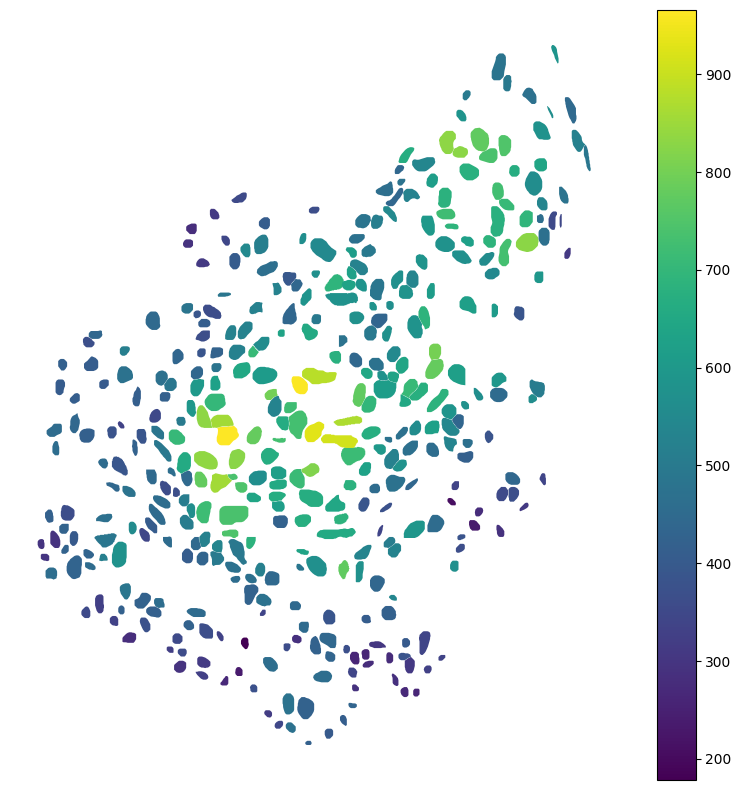

In [3]:
from histolytics.spatial_agg.local_character import local_character

# Let's compute the areas of the nuclei of interest
nuc_of_interest = nuc_of_interest.assign(area=nuc_of_interest.area)

nuc_of_interest = local_character(
    nuc_of_interest, w_neo, val_cols=["area"], id_col="uid", reductions=("mean", "std")
)
ax = nuc_of_interest.plot(
    column="area_nhood_mean", figsize=(10, 10), aspect=1, legend=True
)
ax.set_axis_off()
nuc_of_interest.head(5)

### Local Neighborhood Distances

Another aspect of neighborhood analysis is the spatial arrangement of the nuclei. For example, The degree of packing density of nuclei which can be associated to various phenomena such as different tumor growth patterns. The packing density can be assessed by examining the distances in the nuclei neighborhoods.

To find out how densely packed the neighboring nuclei are, we will compute the mean distances between each neoplastic nucleus and its neighbors. The shorter the mean distance, the denser the neighborhoods are. This shows in the visualization below where denser regions are highlighted in red.

geometry  class_name  uid  \
uid                                                                       
92   POLYGON ((1184.75 1008, 1180 1008.01, 1178.01 ...  connective   92   
95   POLYGON ((1171 1067.02, 1170.01 1068, 1169.01 ...  connective   95   
108  POLYGON ((1178 1113.01, 1175.01 1115.01, 1172....  connective  108   
109  POLYGON ((1226 1174.02, 1224.01 1176.01, 1222....  connective  109   
111  POLYGON ((1208 1211.01, 1203.83 1211.17, 1201....  connective  111   

                                         nhood_classes       area  \
uid                                                                 
92   [connective, inflammatory, neoplastic, connect...  196.21525   
95   [connective, connective, connective, neoplasti...   90.93045   
108  [connective, connective, neoplastic, neoplasti...  415.43035   
109   [connective, neoplastic, connective, connective]  344.17040   
111  [connective, connective, connective, neoplasti...  674.33780   

     area_nhood_mean  area_nhood_std  nhood_dists_mean  
uid                                                     
92        309.868025      195.876801          0.750656  
95        345.139360      183.091297          0.296588  
108       478.860357      304.110999          0.853018  
109       488.513488      124.202886          0.860892  
111       522.122500      244.703536          0.897638

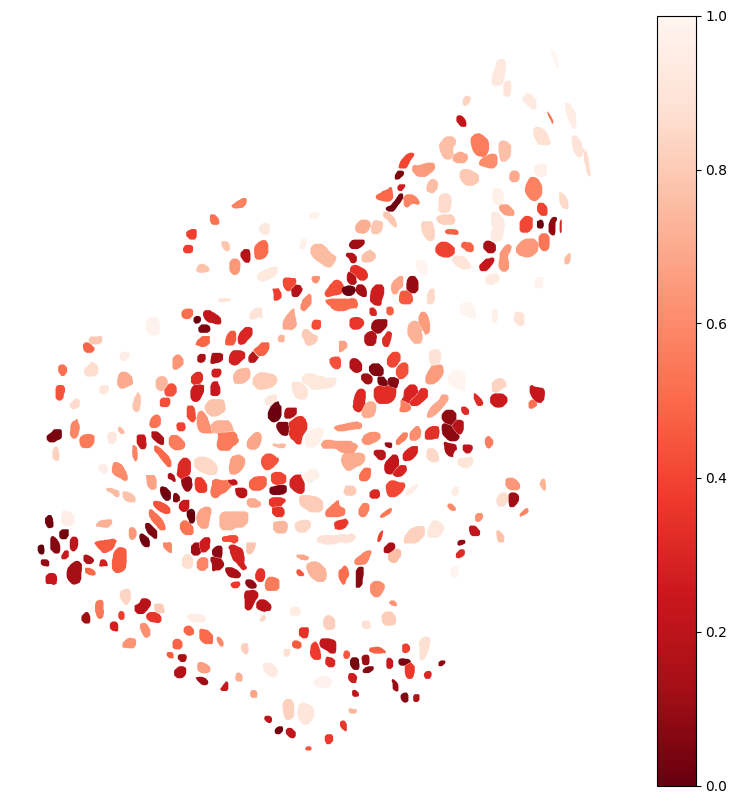

In [4]:
from histolytics.spatial_agg.local_distances import local_distances


# Compute local neighborhood distances
nuc_of_interest = local_distances(
    nuc_of_interest,
    w_neo,
    id_col="uid",
    reductions=["mean"],
    num_processes=6,
    normalize=True,  # we will quantile normalize for the sake of the visualization
)


ax = nuc_of_interest.plot(
    column="nhood_dists_mean", figsize=(10, 10), aspect=1, legend=True, cmap="Reds_r"
)
ax.set_axis_off()
nuc_of_interest.head(5)

### Local Heterogeneities

Next, we will demonstrate how to compute diversity indices for the local neighborhoods of neoplastic nuclei. These indices will help us quantify the compositional variability of the neighborhoods. In principle, the heterogeneity can be computed for any type of numerical or categorical feature. In this demo, we will compute the Shannon diversity index of the cell type categories for the each local neighborhood. The other diversity indices were "simpson_index", "gini_index" and "theil_index"

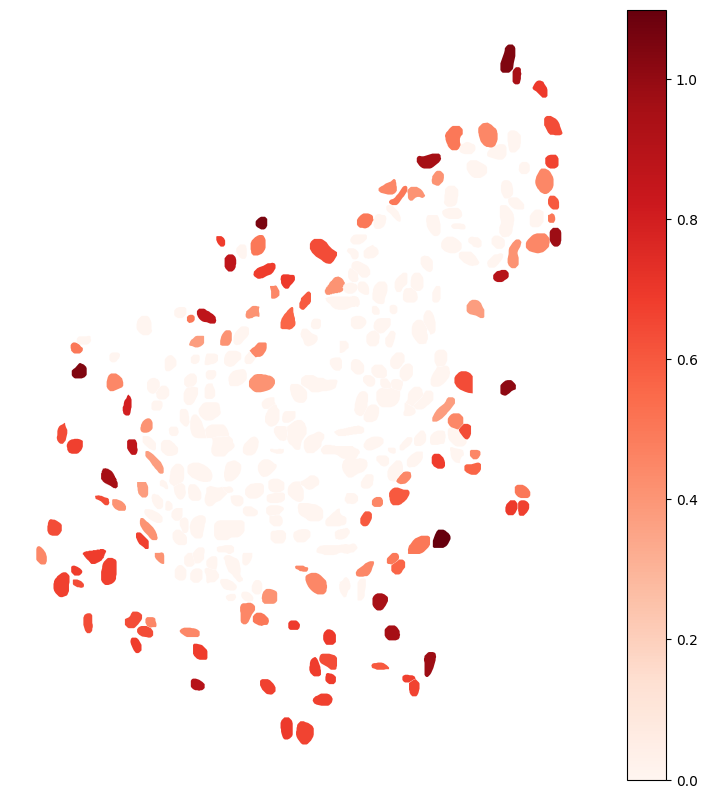

In [5]:
from histolytics.spatial_agg.local_diversity import local_diversity

# Compute local cell type diversity with shannon entropy
nuc_of_interest = local_diversity(
    nuc_of_interest,
    w_neo,
    id_col="uid",
    val_cols=["class_name"],
    metrics=["shannon_index"],
    num_processes=6,
)

# visualize nhood mean areas
ax = nuc_of_interest[nuc_of_interest["class_name"] == "neoplastic"].plot(
    column="class_name_shannon_index",
    aspect=1,
    cmap="Reds",
    legend=True,
    figsize=(10, 10),
)
ax.set_axis_off()

As seen in the visualization, the cell-type heterogeneity is non-zero only at the borders of the tumor nest, where the neoplastic nuclei are linked with the surrounding nuclei in the stroma (e.g. inflammatory and connective nuclei).

### Benchmark

In this section, we will benchmark the performance of different of the local neighborhood metric functions with a cervix dataset containing ~ 19K nuclei. The local neighborhood functions have varying run-times, depending on what and how many metrics are being computed. These functions are parallelizable, so they can be scaled according to the computational resources available. However, the memory usage can also increase significantly when larger datasets are used with many cores. In general, these functions scale to datasets with +1million segmented nuclei with reasonable run-times.

In [6]:
from histolytics.data import cervix_nuclei
from histolytics.utils.gdf import set_uid

nuc = cervix_nuclei()
nuc = set_uid(nuc)
nuc = nuc.assign(area=nuc.area)

w, _ = fit_graph(nuc, method="delaunay", id_col="uid", threshold=50)
nuc

geometry         class_name  \
uid                                                                           
0      POLYGON ((940.01 5570.02, 939.01 5573, 939 559...         connective   
1      POLYGON ((906.01 5350.02, 906.01 5361, 908.01 ...         connective   
2      POLYGON ((866 5137.02, 862.77 5137.94, 860 513...   squamous_epithel   
3      POLYGON ((932 4777.02, 928 4778.02, 922.81 478...  glandular_epithel   
4      POLYGON ((904 5177.02, 902.01 5178.02, 901.01 ...         connective   
...                                                  ...                ...   
19192  POLYGON ((3015 2614.02, 3013.01 2616, 3013.01 ...       inflammatory   
19193  POLYGON ((3387 2618.02, 3384.01 2620.02, 3379....         connective   
19194  POLYGON ((3655 2622.02, 3650.86 2623.75, 3647 ...       inflammatory   
19195  POLYGON ((3703 2627.02, 3699.9 2629.16, 3696.0...         connective   
19196  POLYGON ((3199 2623.02, 3194.64 2626.72, 3191....       inflammatory   

         uid       area  
uid                      
0          0  429.58790  
1          1  408.46570  
2          2  369.49285  
3          3  339.88560  
4          4  330.89425  
...      ...        ...  
19192  19192  297.37560  
19193  19193  293.85250  
19194  19194  320.30200  
19195  19195  300.45640  
19196  19196  268.75830  

[19197 rows x 4 columns]

#### Neighborhood Summary Characteristics

In [7]:
%%timeit
local_character(
    nuc, w, val_cols=["area"], id_col="uid", reductions=("mean",), num_processes=3
)

1.89 s ¬± 26.9 ms per loop (mean ¬± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
local_character(
    nuc, w, val_cols=["area"], id_col="uid", reductions=("mean", "std"), num_processes=6
)

2.14 s ¬± 33.7 ms per loop (mean ¬± std. dev. of 7 runs, 1 loop each)


#### Neighborhood Distances

In [9]:
%%timeit
local_distances(
    nuc,
    w,
    id_col="uid",
    reductions=["mean"],
    num_processes=3,
)

3.53 s ¬± 92.3 ms per loop (mean ¬± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
local_distances(
    nuc,
    w,
    id_col="uid",
    reductions=["mean", "std"],
    num_processes=6,
)

3.88 s ¬± 112 ms per loop (mean ¬± std. dev. of 7 runs, 1 loop each)


#### Neighborhood Diversities

In [11]:
%%timeit
local_diversity(
    nuc,
    w,
    id_col="uid",
    val_cols=["class_name"],
    metrics=["simpson_index"],
    num_processes=3,
)

4.09 s ¬± 71.9 ms per loop (mean ¬± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
local_diversity(
    nuc,
    w,
    id_col="uid",
    val_cols=["class_name"],
    metrics=["simpson_index", "shannon_index"],
    num_processes=6,
)

4.16 s ¬± 41 ms per loop (mean ¬± std. dev. of 7 runs, 1 loop each)
